In [146]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors

import torch as t
import torch_geometric as ptgeo

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx

from gninvert.functions import randrange, run_GN, make_color_scale, gdisplay, run_and_draw, generate_training_data, graphs_loss_func, loss_batch
from gninvert.training import fit
from gninvert.gns import MultiDiffusionGN, EquationGN
from gninvert.gnns import LinearGNN
from gninvert.graph_compare import graph_compare, model_compare
import gninvert

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and inspect model

In [19]:
model_for_sr = t.load('models/sim2-hpmodel2.pt')

In [20]:
model_for_sr.state_dict()

OrderedDict([('m1.weight',
              tensor([[ 0.3574,  0.1953, -0.3580, -0.1956],
                      [ 0.1812, -0.2295, -0.1816,  0.2299]])),
             ('m1.bias', tensor([ 4.7050e-04, -2.7158e-05])),
             ('u1.weight',
              tensor([[ 9.9960e-01,  2.3603e-05, -1.9504e-01, -1.6598e-01],
                      [ 6.0567e-05,  9.9961e-01, -1.5405e-01,  3.0376e-01]])),
             ('u1.bias', tensor([0.0002, 0.0002]))])

Stats for 20 steps for node features:
Greatest relative difference: 61367.041015625%
Average relative difference: 972.9938989877701%
Smallest relative difference: 100.00004768371582%
Greatest absolute difference: 0.00047716498374938965
Average absolute difference: 0.0001261181212612428
Smallest absolute difference: 2.682209014892578e-07%


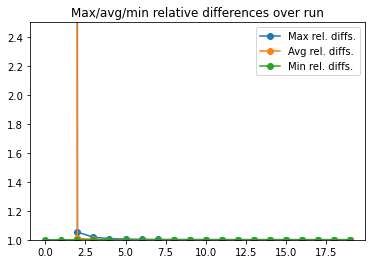

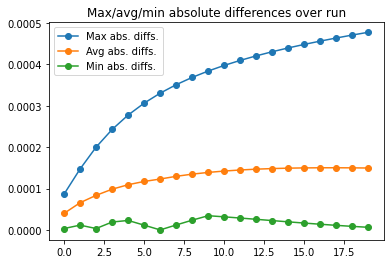

The model being tested finished the run outputting this graph:


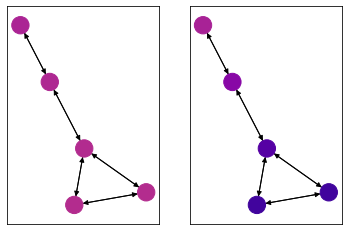

tensor([[0.4092, 0.0992],
        [0.4098, 0.0992],
        [0.4060, 0.1501],
        [0.3943, 0.2797],
        [0.3819, 0.3715]], grad_fn=<AddmmBackward0>)
The ground truth model finished the run outputting this graph:


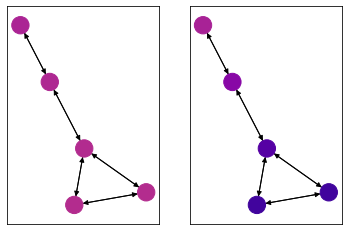

tensor([[0.4091, 0.0992],
        [0.4097, 0.0992],
        [0.4058, 0.1503],
        [0.3940, 0.2798],
        [0.3814, 0.3715]])


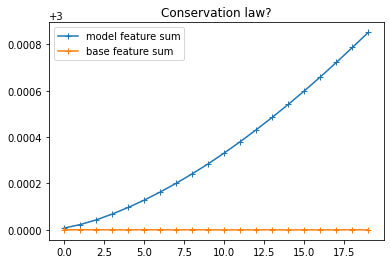

(Data(x=[5, 2], edge_index=[2, 10]), Data(x=[5, 2], edge_index=[2, 10]))

In [21]:
model_compare(model_for_sr, MultiDiffusionGN([0.1, 0.1]))

# Symbolic regression

In [152]:
from gninvert.symbolic_regression import get_pysr_equations, get_best_eq

In [25]:
msg_sr = get_pysr_equations([2, 2], model_for_sr.message)

Activating environment on workers.
      From worker 14:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 17:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 11:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 12:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 13:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 15:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 16:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 10:	  Activating project at `~/.julia/environments/pysr-0.7.7`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 2.200e+03
Head worker occupation: 1.1%
Progress: 11 / 1000 total iterations (1.100%)
Best equations for output 1
Hall of Fame:
--------------------------

In [45]:
upd_sr = get_pysr_equations([2, 2], model_for_sr.update)

Activating environment on workers.
      From worker 22:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 19:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 21:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 25:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 20:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 24:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 23:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 18:	  Activating project at `~/.julia/environments/pysr-0.7.7`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 2.600e+03
Head worker occupation: 1.2%
Progress: 13 / 1000 total iterations (1.300%)
Best equations for output 1
Hall of Fame:
--------------------------

In [62]:
upd_sr2 = get_pysr_equations([2, 2], model_for_sr.update)

Activating environment on workers.
      From worker 38:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 36:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 37:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 35:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 39:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 41:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 40:	  Activating project at `~/.julia/environments/pysr-0.7.7`
      From worker 34:	  Activating project at `~/.julia/environments/pysr-0.7.7`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 1.200e+03
Head worker occupation: 0.5%
Progress: 6 / 1000 total iterations (0.600%)
Best equations for output 1
Hall of Fame:
---------------------------

In [72]:
i = 0
msg_sr.equations[i][msg_sr.equations[i].score == msg_sr.equations[i].score.max()]

,complexity,loss,score,equation,sympy_format,lambda_format
5,11,2.129014e-08,5.810945,((((x0 - x2) * 1.8303506) + (x1 - x3)) * 0.195...,0.357690646828658*x0 + 0.19542193*x1 - 0.35769...,PySRFunction(X=>0.357690646828658*x0 + 0.19542...


In [83]:
import pandas as pd
pd.set_option('display.max_colwidth', None) # to prevent Pandas from truncating the equations

In [120]:
[msg_sr.equations[i][msg_sr.equations[i].score == msg_sr.equations[i].score.max()].iloc[0].sympy_format
for i in range(len(msg_sr.equations))]

[0.357690646828658*x0 + 0.19542193*x1 - 0.357690646828658*x2 - 0.19542193*x3,
 0.181359362712013*x0 - 0.2296651*x1 - 0.181359362712013*x2 + 0.2296651*x3]

In [119]:
[upd_sr.equations[i][upd_sr.equations[i].score == upd_sr.equations[i].score.max()].iloc[0].sympy_format
for i in range(len(upd_sr.equations))]

[-0.19503099*x0 - 0.16597003*x1 + x2,
 -0.154042958143344*x0 + 0.3037682*x1 + x3]

In [118]:
[upd_sr2.equations[i][upd_sr2.equations[i].score == upd_sr2.equations[i].score.max()].iloc[0].sympy_format
for i in range(len(upd_sr2.equations))]

[-0.19504666*x0 - 0.165987779644895*x1 + x2,
 -0.15405114*x0 + 0.30379546*x1 + x3]

In [121]:
(g1, g2) = [
    msg_sr.equations[i][msg_sr.equations[i].score == msg_sr.equations[i].score.max()].iloc[0].lambda_format
    for i in range(len(msg_sr.equations))
]

In [123]:
g1(t.tensor([1, 2, 3, 4]))

tensor(-1.1062)

Note that the above two runs for the update function SR returned essentially identical results

## Equation interpretation

For the trivial graph containing only the edge $x_s \to x_t$, the above equations (if you multiply them out) give an overall update rule of
$$\pmb{x_t}^{\text{next}} = \pmb{x_t}^{\text{now}} + 0.10 (\pmb{x_s} - \pmb{x_t}^{\text{now}})$$

which is exactly correct.

# Compare equation-based GN to original GN

In [133]:
from gninvert.gns import component_fns_to_vector_fn, EquationGN, MultiDiffusionGN

In [106]:
f1 = lambda ts : ts[0] + ts[1]
f2 = lambda ts : ts[0]
f3 = lambda ts : ts[1]
f = component_fns_to_vector_fn([f1, f2, f3])

In [108]:
x = t.tensor([[1, 2], [5, 5]])
x2 = t.tensor([1, 2])
f(x)

tensor([[6, 1, 5],
        [7, 2, 5]])

In [128]:
g = component_fns_to_vector_fn([g1, g2])
g(t.tensor([[0., 1., 2., 3.], [0., 0., 0., 0.]]))

tensor([[-1.1062,  0.0966],
        [ 0.0000,  0.0000]])

In [139]:
equationGN = EquationGN(
    message_fn=[
        msg_sr.equations[i][msg_sr.equations[i].score == msg_sr.equations[i].score.max()].iloc[0].lambda_format
        for i in range(len(msg_sr.equations))
    ],
    update_fn=[
        upd_sr.equations[i][upd_sr.equations[i].score == upd_sr.equations[i].score.max()].iloc[0].lambda_format
        for i in range(len(upd_sr.equations))
    ]
)

Stats for 20 steps for node features:
Greatest relative difference: 13969.837951660156%
Average relative difference: 329.20469999313354%
Smallest relative difference: 100.00027418136597%
Greatest absolute difference: 0.0003120899200439453
Average absolute difference: 0.00010584736628516112
Smallest absolute difference: 1.2218952178955078e-06%


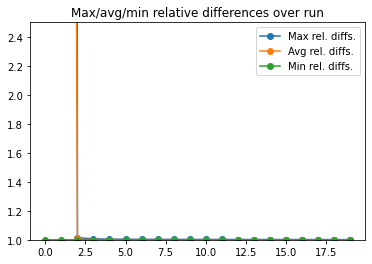

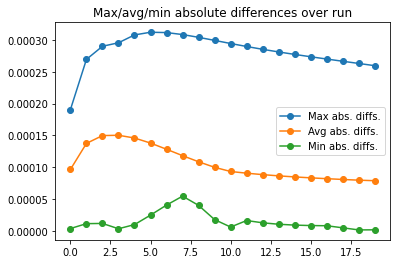

The model being tested finished the run outputting this graph:


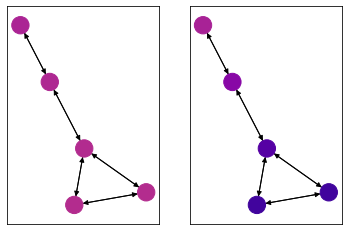

tensor([[0.4091, 0.0991],
        [0.4097, 0.0991],
        [0.4059, 0.1502],
        [0.3940, 0.2799],
        [0.3814, 0.3718]])
The ground truth model finished the run outputting this graph:


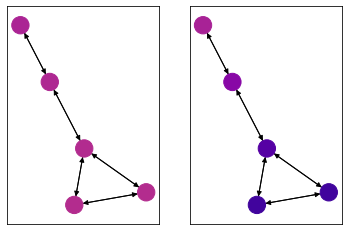

tensor([[0.4091, 0.0992],
        [0.4097, 0.0992],
        [0.4058, 0.1503],
        [0.3940, 0.2798],
        [0.3814, 0.3715]])


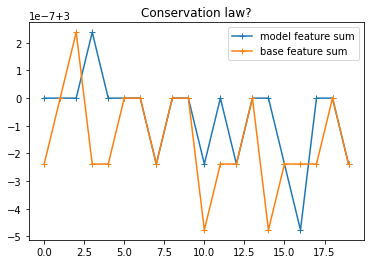

(Data(x=[5, 2], edge_index=[2, 10]), Data(x=[5, 2], edge_index=[2, 10]))

In [140]:
model_compare(equationGN, MultiDiffusionGN([0.1, 0.1]))

# ANOTHER MODEL

In [141]:
model2 = t.load('models/sim2-L2.pt')

Stats for 20 steps for node features:
Greatest relative difference: 68349.82299804688%
Average relative difference: 1026.601972579956%
Smallest relative difference: 100.0004768371582%
Greatest absolute difference: 0.0008660256862640381
Average absolute difference: 0.0002922489260527072
Smallest absolute difference: 2.7567148208618164e-07%


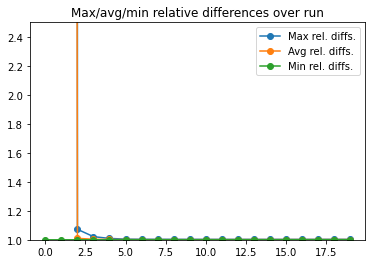

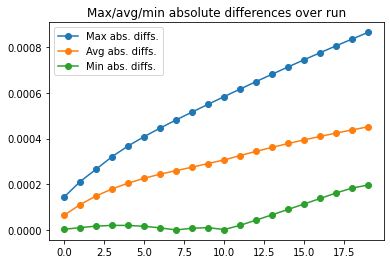

The model being tested finished the run outputting this graph:


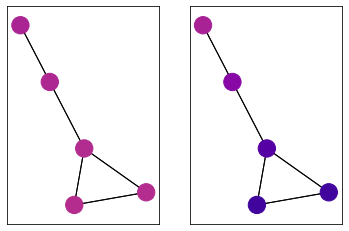

tensor([[0.4082, 0.0990],
        [0.4088, 0.0990],
        [0.4050, 0.1498],
        [0.3938, 0.2795],
        [0.3817, 0.3713]], grad_fn=<AddmmBackward0>)
The ground truth model finished the run outputting this graph:


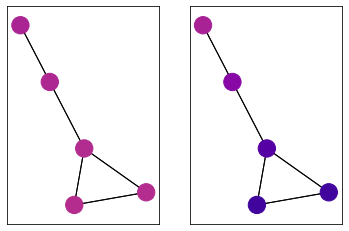

tensor([[0.4091, 0.0992],
        [0.4097, 0.0992],
        [0.4058, 0.1503],
        [0.3940, 0.2798],
        [0.3814, 0.3715]])


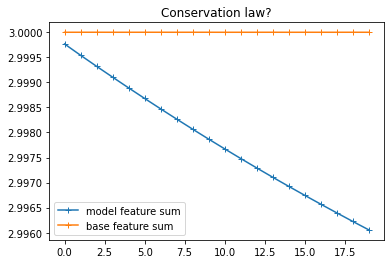

(Data(x=[5, 2], edge_index=[2, 10]), Data(x=[5, 2], edge_index=[2, 10]))

In [142]:
model_compare(model2, MultiDiffusionGN([0.1, 0.1]))

In [154]:
msg_sr2 = get_pysr_equations([2, 2], model2.message)

Started!

Cycles per second: 1.960e+02
Head worker occupation: 0.0%
Progress: 1 / 1000 total iterations (0.100%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           9.451e-02  -1.797e+00  0.26892877
3           1.389e-02  9.587e-01  (x0 * -0.041221548)
5           1.317e-02  2.665e-02  ((x0 * -0.025099056) / 0.26892877)
7           8.337e-03  2.287e-01  (((x2 * 0.2969441) - 0.066107675) + -0.088956565)
9           6.611e-03  1.160e-01  (((x0 - x2) * -0.041221548) / (0.1925218 / x0))
11          3.851e-03  2.703e-01  ((((x0 - x2) * -0.1287598) / (0.26600018 / x0)) / 1.1748769)
13          1.084e-04  1.785e+00  (((x0 - x2) * -58.01392) / ((7.6465116 / x0) / (0.041747138 / x0)))
15          1.084e-04  2.520e-08  ((((x0 - x2) * 21.883566) / ((-4.9362793 / x0) / (0.20655186 / x0))) / 2.891017)
17          1.083e-04  7.874e-04  ((((x0 - x2) * -13.511829) / ((5.645386 / x0) / ((0.2765239 / x0) + 0.002781664)

In [155]:
upd_sr2 = get_pysr_equations([2, 2], model2.update)

------------------
Complexity  Loss       Score     Equation
1           1.748e-02  1.025e-07  0.0040044123
3           1.527e-02  6.742e-02  (x3 * 0.08330163)
5           5.425e-05  2.820e+00  ((x3 - x1) * 0.3406765)
7           5.390e-05  3.301e-03  ((x3 - (x1 + -0.0017539561)) * 0.34063536)
9           5.233e-05  1.472e-02  (((x3 - x1) * 0.34067452) - (6.6642184e-5 / x0))
11          4.550e-05  6.995e-02  (((x1 - (x3 - (x0 * -0.0146726705))) * -0.30296734) / 0.8902979)
13          2.856e-05  2.328e-01  (((x1 - ((x3 - (x0 * -0.05164427)) - 0.025031803)) * -0.34600464) / 1.0178277)
17          2.855e-05  1.444e-04  (((x1 + ((0.024148762 - (x0 * 0.051581282)) - (x3 + x3))) * -0.3402486) + (x3 * -0.34084886))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 9.740e+03
Head worker occupation: 1.1%
Progress: 356 / 1000 total iterations (35.600%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equat

In [163]:
get_best_eq(msg_sr2)

[-0.3149621*x0 + 0.026919892577146*x1 + 0.3149621*x2 - 0.026919892577146*x3,
 0.018652335*x0 - 0.3393942*x1 - 0.018652335*x2 + 0.3393942*x3]

In [164]:
get_best_eq(upd_sr2)

[0.31838915*x0 + 0.02532003*x1 + x2, 0.01760922*x0 + 0.29559484*x1 + x3]